In [1]:
!pip install -U torch==1.8.0 torchtext==0.9.0
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 783.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Uninstalling torch-1.8.0:
      Successfully uninstalled torch-1.8.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled torchaudio-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into acc

In [2]:
import torch
import json
from torchtext.legacy import data
import torch.nn as nn
import torch.optim as optim
import time
from torch.nn import Embedding

import random
import math

import matplotlib.pyplot as plt

In [3]:
! pip install datasets transformers > /dev/null

In [4]:
squad_v2 = False
model_checkpoint = "bert-large-uncased-whole-word-masking-finetuned-squad"
batch_size = 32

In [5]:
import tensorflow as tf
from datasets import load_dataset, load_metric
datasets = load_dataset("squad_v2" if squad_v2 else "squad")

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [7]:
datasets["train"][15]

{'id': '5733a6424776f41900660f51',
 'title': 'University_of_Notre_Dame',
 'context': 'The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study – aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering – with eight B.S. degrees offered. Additionally, the college offers five-year dual degree programs with the Colleges of Arts and Letters and of Business awarding additional B.A. and Master of Business Administration (MBA) degrees, respectively.',
 'question': 'How many BS level degrees are offered in the College of Engineering at Notre Dame?',
 'answers': {'text': ['eight'], 'answer_start': [487]}}

In [8]:
datasets["validation"][0]

{'id': '56be4db0acb8001400a502ec',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Which NFL team represented the AFC at Super Bowl 50?',
 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],


In [9]:
def get_examples(file):
  examples=[]
  for i in datasets[file]:
    context=i['context']
    question=i['question']
    answer=i['answers']
    examples.append([context, question, answer])
  return examples

In [10]:
def get_data(train_file, test_file):
    train_examples = get_examples(train_file)
    validation_examples = get_examples(validation_file)

    context_with_question = data.Field(sequential = True, tokenize = 'spacy', init_token = '<sos>', eos_token = '<eos>')
    answer = data.Field(sequential = True, tokenize = 'spacy', init_token = '<sos>', eos_token = '<eos>')
    fields = [('context', context_with_question), ('answer', answer)]
    train_Examples = [data.Example.fromlist([i[0], i[1]], fields) for i in train_examples]
    train_dataset = data.Dataset(train_Examples, fields)

    validation_Examples = [data.Example.fromlist([i[0], i[1]], fields) for i in validation_examples]
    validation_dataset = data.Dataset(validation_Examples, fields)

    context_with_question.build_vocab(train_dataset, min_freq = 2, max_size = 30000,vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)
    answer.vocab = context_with_question.vocab
    return context_with_question, answer, train_dataset, validation_dataset


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)  # no dropout as only one layer!
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)  # no cell state!
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        emb_con = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)),
                           dim=1)
        prediction = self.fc_out(output)
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

def init_weights(m):
    for name, param in m.named_parameters():
        if not isinstance(m, Embedding):
            nn.init.normal_(param.data, mean=0, std=0.01)

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.context
        trg = batch.answer
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.context
            trg = batch.answer
            output = model(src, trg, 0)  # turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def model_training(epochs):
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        start_time = time.time()
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, test_iterator, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut2-model.pt')

        train_loss_PPL = math.exp(train_loss)
        valid_loss_PPL = math.exp(valid_loss)
        print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_loss_PPL:7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_loss_PPL:7.3f}')

        return train_loss, valid_loss, train_loss_PPL, valid_loss_PPL

Epoch: 01 | Time: 7m 6s
	Train Loss: 5.832 | Train PPL: 341.189
	 Val. Loss: 5.925 |  Val. PPL: 374.441
Epoch: 01 | Time: 7m 4s
	Train Loss: 5.356 | Train PPL: 211.896
	 Val. Loss: 5.854 |  Val. PPL: 348.465
Epoch: 01 | Time: 7m 1s
	Train Loss: 5.095 | Train PPL: 163.184
	 Val. Loss: 5.789 |  Val. PPL: 326.635
Epoch: 01 | Time: 6m 57s
	Train Loss: 4.840 | Train PPL: 126.448
	 Val. Loss: 5.740 |  Val. PPL: 311.046
Epoch: 01 | Time: 6m 57s
	Train Loss: 4.620 | Train PPL: 101.465
	 Val. Loss: 5.707 |  Val. PPL: 300.914


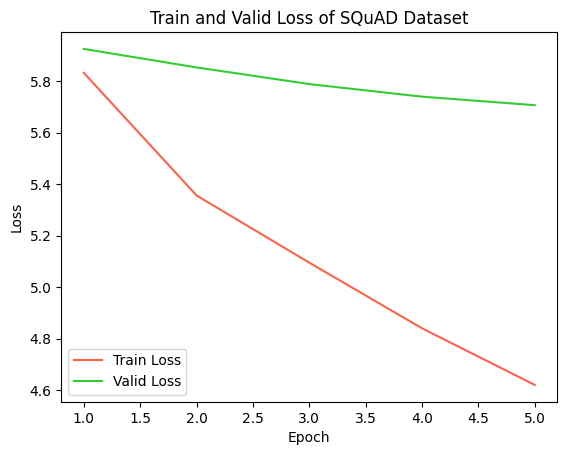

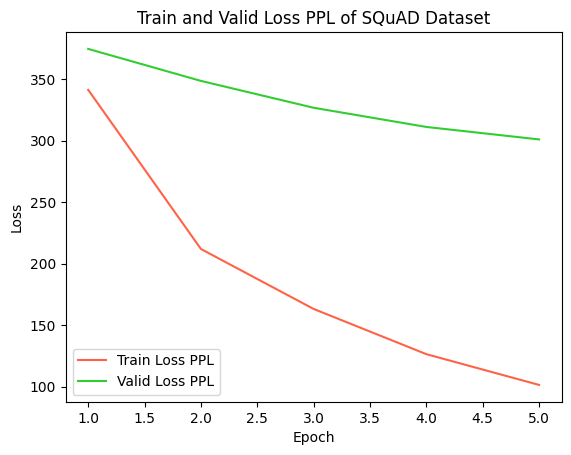

In [13]:
if __name__ == "__main__":
    question_pad = ' @qpad '

    BATCH_SIZE = 128
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_file = "train"
    validation_file = "validation"
    context_with_question, answer, train_dataset, validation_dataset = get_data(train_file, validation_file)
    #validation_dataset= get_data(validation_file)
    train_iterator, test_iterator = data.BucketIterator.splits(
        (train_dataset, validation_dataset), batch_size = BATCH_SIZE,
        sort_key = lambda x: len(x.context), sort_within_batch = True, device = device)

    INPUT_DIM = len(context_with_question.vocab)
    OUTPUT_DIM = len(context_with_question.vocab)
    ENC_EMB_DIM = 100
    DEC_EMB_DIM = 100
    HID_DIM = 200
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5

    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Seq2Seq(enc, dec, device).to(device)
    model.apply(init_weights)
    optimizer = optim.Adam(model.parameters())
    TRG_PAD_IDX = answer.vocab.stoi[answer.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

    epochs = 5
    CLIP = 1

    train_loss_list = []
    valid_loss_list = []
    train_loss_PPL_list = []
    valid_loss_PPL_list = []
    epoch_list = [i for i in range(1, epochs + 1)]

    for epoch in range(epochs):
        train_loss, valid_loss, train_loss_PPL, valid_loss_PPL = model_training(epochs)

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_loss_PPL_list.append(train_loss_PPL)
        valid_loss_PPL_list.append(valid_loss_PPL)

    # Training & Testing Accuracy Plot
    plt.plot(epoch_list, train_loss_list, color = 'tomato', label = 'Train Loss')
    plt.plot(epoch_list, valid_loss_list, color = 'limegreen', label = 'Valid Loss')
    plt.legend(loc = 'lower left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Valid Loss of SQuAD Dataset')
    plt.show()

    # Training & Testing Loss Plot
    plt.plot(epoch_list, train_loss_PPL_list, color = 'tomato', label = 'Train Loss PPL')
    plt.plot(epoch_list, valid_loss_PPL_list, color = 'limegreen', label = 'Valid Loss PPL')
    plt.legend(loc = 'lower left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Valid Loss PPL of SQuAD Dataset')
    plt.show()